# This is the Saildrone and CCMP collocation code. 


In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr

def get_ccmp_filename(date):
    dir_ccmp='F:/data/sat_data/ccmp/v02.0/'
    syr, smon, sdym = str(date.dt.year.data), str(date.dt.month.data).zfill(2), str(date.dt.day.data).zfill(2)
    ccmp_filename =dir_ccmp + 'Y' + syr + '/M' + smon + '/CCMP_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    exists = os.path.isfile(ccmp_filename)
    if exists==False:
        ccmp_filename =dir_ccmp + 'Y' + syr + '/M' + smon + '/CCMP_RT_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
        exists = os.path.isfile(ccmp_filename)
    return ccmp_filename, exists


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.

There are 6 NaN values in the lat/lon data arrays, interpolate across these

We want to collocate with wind vectors for this example,  but the wind vectors are only every 10 minutes rather than every minute, so use .dropna to remove all values in the dataset from all dataarrays when wind vectors aren't availalbe

In [43]:
filename_collocation_data = 'F:/data/cruise_data/saildrone/baja-2018/ccmp_collocation_data.nc'
#filename_usv = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-11T18:30',ds_usv.time[-1].data))  #first part of data is when USV being towed, elminiate
ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
#usv is at 5 m, buoys are at 5m.  leave alone rather than changing to 10m wind
#ut*log(10/1e-4)/log(zu/1e-4)
ds_usv['UWND_MEAN'] = ds_usv.UWND_MEAN*(np.log(10./1e-4)/np.log(5.0/1e-4))
ds_usv['VWND_MEAN'] = ds_usv.VWND_MEAN*(np.log(10./1e-4)/np.log(5.0/1e-4))
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
ds_usv_subset = ds_usv.dropna(dim='time',subset={'UWND_MEAN'})   #get rid of all the nan
#print(ds_usv_subset.UWND_MEAN[2000:2010].values)

In order to use open_mfdataset you need to either provide a path or a list of filenames to input

Here we use the USV cruise start and end date to read in all CCMP wind vector data for that period

In [44]:
read_date,end_date = ds_usv_subset.time.min(),ds_usv_subset.time.max()
filelist = []
while read_date<=(end_date+np.timedelta64(1,'D')):
    tem_filename, exists = get_ccmp_filename(read_date)
    if exists:
        filelist.append(tem_filename)
    read_date=read_date+np.timedelta64(1,'D')
#print(filelist)

# Read in CCMP data
Read in data using open_mfdataset with the option coords='minimal'

CCMP data uses long names for lat/lon so change that and then chage coordinate system to -180 to 180 from 0 to 360

The dataset is printed out and you can see that rather than straight xarray data array for each of the data variables open_mfdataset using dask arrays

In [45]:
ds_sat = xr.open_mfdataset(filelist,coords='minimal')
ds_sat = ds_sat.rename({'longitude':'lon','latitude':'lat'}) 
ds_sat = ds_sat.assign_coords(lon=(((ds_sat.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
ds_sat

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, time: 248)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * time     (time) datetime64[ns] 2018-04-11 ... 2018-06-11T18:00:00
Data variables:
    uwnd     (time, lat, lon) float32 dask.array<shape=(248, 628, 1440), chunksize=(4, 628, 1440)>
    vwnd     (time, lat, lon) float32 dask.array<shape=(248, 628, 1440), chunksize=(4, 628, 1440)>
    nobs     (time, lat, lon) float32 dask.array<shape=(248, 628, 1440), chunksize=(4, 628, 1440)>
Attributes:
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP_RT V2.1 derived surface winds (Level...
    history:                    20180426T175522ZZ - netCDF generated from ori...
    description:                RSS VAM 6-hour analyses starting fr

# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons

1. Now load the data into memory (de-Dask-ify) it  


In [46]:
#Step 1 from above
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))
#Step 2 from above
subset.load()
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [47]:
#print(ds_collocated_nearest.uwnd[244:315].data)
#print(masked_usv.UWND_MEAN[244:315].data)
#print(masked_usv.UWND_MEAN[244:315].mean().data)
print(masked_usv.time.min().data)
print(masked_usv.time.max().data)
print(masked_usv.lon.min().data)
print(masked_usv.lon.max().data)
print(masked_usv.time[0].data,masked_usv.time[-1].data)

NameError: name 'masked_usv' is not defined

In [48]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.uwnd[index]):
        continue
    if np.isnan(ds_tem.uwnd[index]):
        continue
    print(index, ilen)
    cond = ((ds_tem.uwnd==ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
    notcond = np.logical_not(cond)
    masked = ds_tem.where(cond)
    masked_usv = ds_usv_subset.where(cond,drop=True)
    if masked.uwnd.sum().data==0:  #don't do if data not found
        continue
    duu=np.append(duu,masked_usv.UWND_MEAN.mean().data)
    dvu=np.append(dvu,masked_usv.VWND_MEAN.mean().data)
    dlat=np.append(dlat,masked_usv.lat.mean().data)
    dlon=np.append(dlon,masked_usv.lon.mean().data)
    tdif = masked_usv.time[-1].data-masked_usv.time[0].data
    mtime=masked_usv.time[0].data+np.timedelta64(tdif/2,'ns')
    dut=np.append(dut,mtime)
    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/ccmp_downsampled_usv_data.nc')

244 17583
315 17583
324 17583
334 17583
393 17583
406 17583
421 17583
448 17583
478 17583
519 17583
550 17583
622 17583
676 17583
694 17583
728 17583
731 17583
766 17583
799 17583
817 17583
838 17583
846 17583
894 17583
910 17583
982 17583
1054 17583
1055 17583
1126 17583
1139 17583
1198 17583
1199 17583
1212 17583
1270 17583
1296 17583
1342 17583
1414 17583
1486 17583
1497 17583
1536 17583
1558 17583
1563 17583
1627 17583
1630 17583
1631 17583
1697 17583
1702 17583
1716 17583
1745 17583
1747 17583
1774 17583
1816 17583
1829 17583
1846 17583
1870 17583
1918 17583
1919 17583
1966 17583
1990 17583
1997 17583
2003 17583
2042 17583
2062 17583
2068 17583
2090 17583
2134 17583
2138 17583
2162 17583
2206 17583
2210 17583
2278 17583
2283 17583
2350 17583
2356 17583
2405 17583
2422 17583
2459 17583
2494 17583
2502 17583
2541 17583
2566 17583
2582 17583
2609 17583
2638 17583
2642 17583
2710 17583
2716 17583
2782 17583
2804 17583
2854 17583
2923 17583
2926 17583
2949 17583
2998 17583
3045 17583
3

PermissionError: [Errno 13] Permission denied: b'F:\\data\\cruise_data\\saildrone\\baja-2018\\ccmp_downsampled_usv_data.nc'

In [49]:
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/ccmp_downsampled_usv_data2.nc')

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\coding\times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [50]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
    lat      (time) float64 37.59 37.52 37.48 37.36 ... 37.42 37.5 37.51 37.57
    lon      (time) float64 -122.6 -122.8 -122.8 -122.8 ... -123.0 -123.0 -122.9
  * time     (time) datetime64[ns] 2018-04-11T23:59:30 ... 2018-06-10T16:20:00
Data variables:
    uwnd     (time) float64 2.516 3.642 4.272 6.657 ... 5.518 6.036 6.138 6.729
    vwnd     (time) float64 4.376 1.877 0.6597 -3.574 ... -8.595 -8.451 -7.55
    nobs     (time) float64 4.407e-06 0.0 0.0 0.0 ... 0.5766 0.4633 0.06426
Attributes:
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP_RT V2.1 derived surface winds (Level...
    history:                    20180426T175522ZZ - netCDF generated from ori...
    description:                RSS VAM 6-hour analyses starting from the NCE...
    summary:                    CCMP_RT V2.1 has be

In [51]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/ccmp_downsampled_collocated_usv_data2.nc')


In [52]:
#read in the collocated data
ds_collocated_averaged = xr.open_dataset('F:/data/cruise_data/saildrone/baja-2018/ccmp_downsampled_collocated_usv_data2.nc')
ds_new = xr.open_dataset('F:/data/cruise_data/saildrone/baja-2018/ccmp_downsampled_usv_data2.nc')

#usv is at 5 m, buoys are at 5m.  leave alone rather than changing to 10m wind
#ut*log(10/1e-4)/log(zu/1e-4)
#ds_new['u_usv'] = (ds_new.u_usv*np.log(10./1e-4))/np.log(5.0/1e-4)
#ds_new['v_usv'] = (ds_new.v_usv*np.log(10./1e-4))/np.log(5.0/1e-4)


In [53]:
ds_collocated_averaged['spd']=np.sqrt(ds_collocated_averaged.uwnd**2+ds_collocated_averaged.vwnd**2)
ds_new['spd'] = np.sqrt(ds_new.u_usv**2+ds_new.v_usv**2)
ds_collocated_averaged['dir']=np.arctan2(ds_collocated_averaged.vwnd,ds_collocated_averaged.uwnd)*180./np.pi
ds_new['dir'] = np.arctan2(ds_new.v_usv,ds_new.u_usv)*180./np.pi

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360


sdif = dif_spd.dropna('time')
sdifcor = np.corrcoef(sat_spd,usv_spd)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])
sdif = dif_dir.dropna('time')
sdifcor = np.corrcoef(sat_dir,usv_dir)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])



print('mean,std dif speed',[dif_spd.mean().data,dif_spd.std().data])
print('mean,std dir',[dif_dir.mean().data,dif_dir.std().data,dif_spd.shape[0]])




[array(0.60342809), array(0.50393924), 0.9026515341369429, array(1.10362682), 0.922214333205819, array(0.92219838), 492]
[array(-3.43623632), array(-3.06462274), 0.5836644364078865, array(14.03136331), 6.385373887579686, array(7.78350898), 492]
mean,std dif speed [array(0.60342809), array(1.10362682)]
mean,std dir [array(-3.43623632), array(14.03136331), 492]


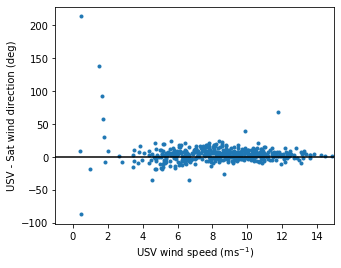

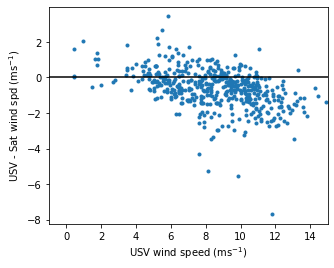

In [54]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,sat_dir-usv_dir,'.')
ax.plot([-1,15],[0,0],'k')
ax.set_xlim([-1,15])
ax.set_xlabel('USV wind speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat wind direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_wdir_wspd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,sat_spd-usv_spd,'.')
ax.plot([-1,15],[0,0],'k')
ax.set_xlim([-1,15])
ax.set_xlabel('USV wind speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat wind spd (ms$^{-1}$)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_wdir_spd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


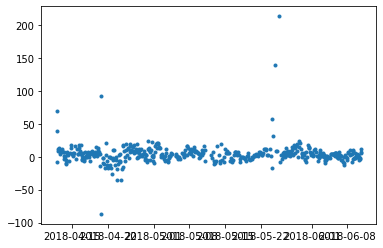

In [33]:
plt.plot(ds_new.time,sat_dir-usv_dir,'.')

In [ ]:
#faster not sure why
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu,dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.uwnd[index]):
        continue
    test = ds_collocated_nearest.where((ds_tem.uwnd==ds_collocated_nearest.uwnd[index])&(ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
    test = test/test
    if test.uwnd.sum()>0:
        duu=np.append(duu,(ds_usv_subset.UWND_MEAN*test.uwnd).mean().data)
        dvu=np.append(dvu,(ds_usv_subset.VWND_MEAN*test.vwnd).mean().data)
        dlat=np.append(dlat,(ds_usv_subset.lat*test.lat).mean().data)
        dlon=np.append(dlon,(ds_usv_subset.lon*test.lon).mean().data)
        tdif = ds_usv_subset.time.where(test.vwnd==1).max().data-ds_usv_subset.time.where(test.vwnd==1).min().data
        mtime=ds_usv_subset.time.where(test.vwnd==1).min().data+np.timedelta64(tdif/2,'ns')
        dut=np.append(dut,mtime)
        ds_tem=ds_tem.where(np.isnan(test),np.nan)  #you have used values, so set to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new2=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})


In [ ]:
#testing code above
ds_tem = ds_collocated_nearest.copy(deep=True)
print(ds_collocated_nearest.uwnd[1055].data)
print(ds_collocated_nearest.uwnd[1050:1150].data)
test = ds_collocated_nearest.where((ds_collocated_nearest.uwnd==ds_collocated_nearest.uwnd[1055])&(ds_collocated_nearest.vwnd==ds_collocated_nearest.vwnd[1055]))
test = test/test
print(test.uwnd[1050:1150].data)
ds_tem=ds_tem.where(np.isnan(test),np.nan)
print(ds_tem.uwnd[1050:1150].data)
print((ds_usv_subset.UWND_MEAN*test.uwnd).mean())
print((ds_usv_subset.VWND_MEAN*test.vwnd).mean())


In [ ]:
from scipy.interpolate import griddata
# interpolate
points = (ds_usv_subset.lon.data,ds_usv_subset.lat.data)
grid_in_lon,grid_in_lat = np.meshgrid(subset.lon.data,subset.lat.data)
grid_in = (grid_in_lon,grid_in_lat)
values = ds_usv_subset.UWND_MEAN.data
#print(points.size)
zi = griddata(points,values,grid_in,method='linear',fill_value=np.nan)
zi2 = griddata(points,values/values,grid_in,method='linear',fill_value=np.nan)
print(np.isfinite(zi).sum())

In [ ]:
plt.pcolormesh(subset.lon,subset.lat,zi,vmin=-5,vmax=5)
plt.plot(ds_usv_subset.lon,ds_usv_subset.lat,'.')
#plt.contourf(subset.uwnd[0,:,:])

In [ ]:
len(points[0])

In [ ]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

THRESHOLD=1
# Construct kd-tree, functionality copied from scipy.interpolate
tree = cKDTree(points)
xi = _ndim_coords_from_arrays(grid_in, ndim=len(points[0]))
dists, indexes = tree.query(xi)

# Copy original result but mask missing values with NaNs
result3 = result2[:]
result3[dists > THRESHOLD] = np.nan

# Show
plt.figimage(result3)
plt.show()

In [ ]:
#testing
index=300
ds_tem = ds_collocated_nearest.copy(deep=True)
cond = ((ds_tem.uwnd==ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
notcond = ((ds_tem.uwnd!=ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd!=ds_collocated_nearest.vwnd[index]))
masked = ds_tem.where(cond)
masked_usv = ds_usv_subset.where(cond,drop=True)
print(masked.uwnd.sum().data)
#print(masked.nobs[290:310].data)
print((masked_usv.UWND_MEAN).mean().data)
print(ds_tem.uwnd[243:316])
ds_tem=ds_tem.where(notcond,np.nan)  #you have used values, so set to nan
print(ds_tem.uwnd[243:316])
